In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(
    rc={
        "lines.linewidth": 3,
        "grid.linestyle": "--",
        "grid.color": "gray"
    }
)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = ['Times New Roman']
# plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["axes.facecolor"] = "#f7f7f7"
plt.rcParams["font.size"] = 24
plt.rcParams["figure.dpi"] = 300

In [35]:
domain = "fourroom"
metric = "time_to_threshold_50"
data_df = pd.read_csv(f"../notebooks/in/{domain}/{metric}.csv", index_col=0)
data_df.head()

,DYN-HUMAN-,DYN-RANDOM-,STATIC-HUMAN-,STATIC-RANDOM-,SARSA-,NRS-,LINRS-
0,43,37,31,43,25,56,38
1,38,32,50,34,49,57,63
2,38,48,24,32,41,49,52
3,31,50,12,61,46,27,37
4,55,54,51,48,69,52,65


In [36]:
data_df.describe()

,DYN-HUMAN-,DYN-RANDOM-,STATIC-HUMAN-,STATIC-RANDOM-,SARSA-,NRS-,LINRS-
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,37.771000,43.932000,35.899000,43.78000,51.612000,47.043000,46.893000
std,11.066573,11.560667,11.647767,68.00456,16.317467,14.943107,15.441956
min,7.000000,6.000000,3.000000,5.00000,13.000000,7.000000,7.000000
25%,30.000000,36.750000,28.000000,29.00000,39.000000,38.000000,37.000000
50%,38.000000,44.000000,36.000000,37.00000,52.000000,48.000000,46.000000
75%,45.000000,52.000000,44.000000,46.25000,64.000000,57.000000,57.000000
max,70.000000,75.000000,67.000000,863.00000,84.000000,97.000000,86.000000


In [37]:
keep_order = {
    "DYNAMIC": 1,
    "STATIC": 2,
    "SARSA": 3,
    "LINRS": 4,
    "NRS": 5,
}
keep_order

{'DYNAMIC': 1, 'STATIC': 2, 'SARSA': 3, 'LINRS': 4, 'NRS': 5}

In [38]:
target_data_df = data_df.loc[:99, ["DYN-HUMAN-", "STATIC-HUMAN-", "SARSA-", "LINRS-", "NRS-"]].rename(
    columns={
        "DYN-HUMAN-": "DYNAMIC", "STATIC-HUMAN-": "STATIC",
        "SARSA-": "SARSA", "LINRS-": "LINRS", "NRS-": "NRS"
    }
)
target_data_df.to_csv(f"./csv/{metric}_{domain}_data.csv")

In [39]:
stack_data_df = target_data_df.stack().reset_index(level=1).rename(
    columns={"level_1": "method", 0: "value"}
)
stack_data_df["sort_value"] = stack_data_df["method"].apply(lambda x: keep_order[x])
stack_data_df = stack_data_df.sort_values("sort_value")
stack_data_df[["value"]].to_csv(f"./csv/{metric}_{domain}_stacked_data.csv", index=False, header=False)
stack_data_df

,method,value,sort_value
0,DYNAMIC,43,1
35,DYNAMIC,14,1
36,DYNAMIC,40,1
37,DYNAMIC,47,1
92,DYNAMIC,26,1
...,...,...,...
57,NRS,58,5
58,NRS,58,5
59,NRS,34,5
61,NRS,42,5


# Boxplot

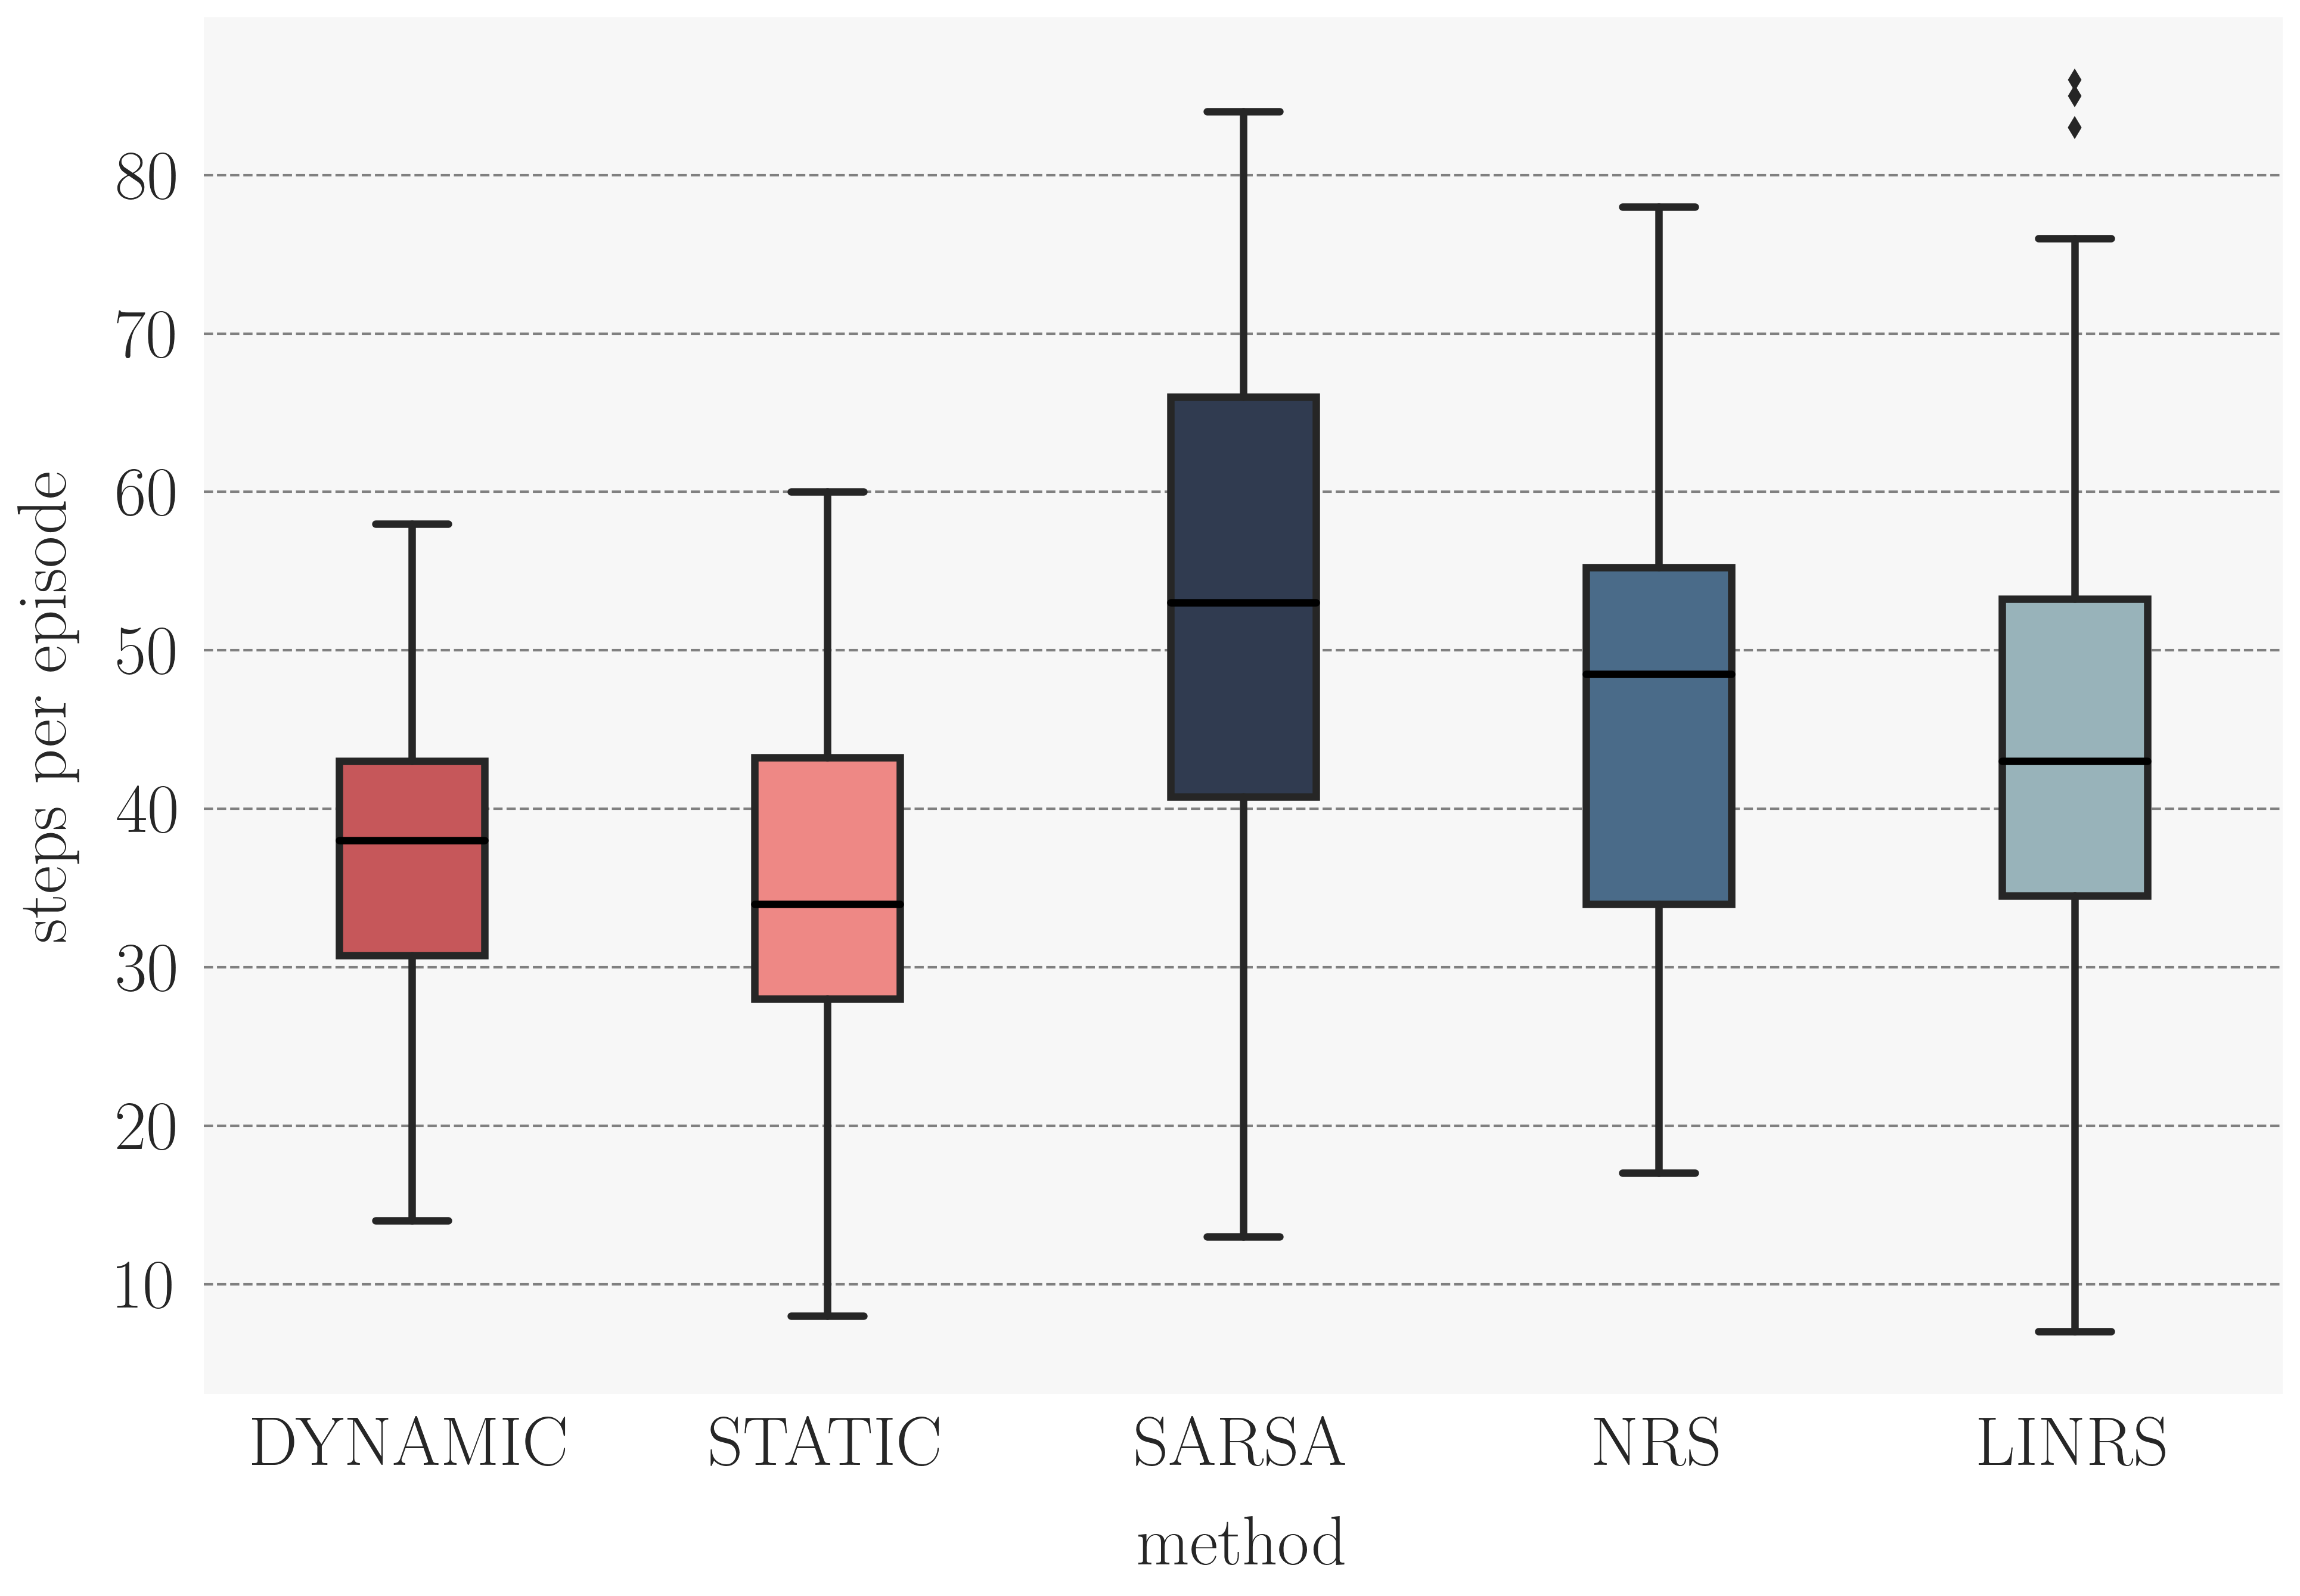

In [40]:
plt.figure(figsize=(15, 10))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tick_params(bottom=False, labelsize=28)
bp = sns.boxplot(
    x="method", y="value", data=stack_data_df, width=0.35,
    palette=["#d94448", "#ff7774", "#2b3955", "#406c93", "#92b7c0"],
    medianprops=dict(color="black"),
    order=["DYNAMIC", "STATIC", "SARSA", "NRS", "LINRS"],
)
# plt.ylim(0, 1100)
plt.ylabel("steps per episode", labelpad=15, fontsize=28)
plt.xlabel("method", labelpad=15, fontsize=28)
plt.savefig(f"out/boxplot_{metric}_{domain}.pdf", format="pdf")

# 有意差

In [47]:
from stat_test import barplot_annotate_brackets

In [48]:
def bar_plot_with_asterisk(metric, domain, target_data_df, asterisk_tuples):
    plt.figure(figsize=(15, 10))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.tick_params(bottom=False, labelsize=28)
    means, sems = target_data_df.mean().values, target_data_df.sem().values
    # 平均値の比較の場合は平均値推定の精度を示す標準誤差をエラーバーとする
    # https://corvus-window.com/all_error-bar/
    bars = np.arange(len(target_data_df.columns))
    plt.grid(axis="x")
    plt.bar(
        bars, means,
        tick_label=target_data_df.columns.tolist(),
        yerr=sems,
        capsize=15.0,
        error_kw={"capthick": 3.0},
        align='center',
        color=["#d94448", "#ff7774", "#2b3955", "#406c93", "#92b7c0"]
    )
    barplot_annotate_brackets(asterisk_tuples, bars, means.tolist(), yerr=sems.tolist(), offset_basis=0)
    plt.ylabel("steps per episode", labelpad=15, fontsize=28)
    plt.xlabel("method", labelpad=15, fontsize=28)
    plt.savefig(f"out/barplot_{metric}_{domain}.pdf", format="pdf")

# Fourrom

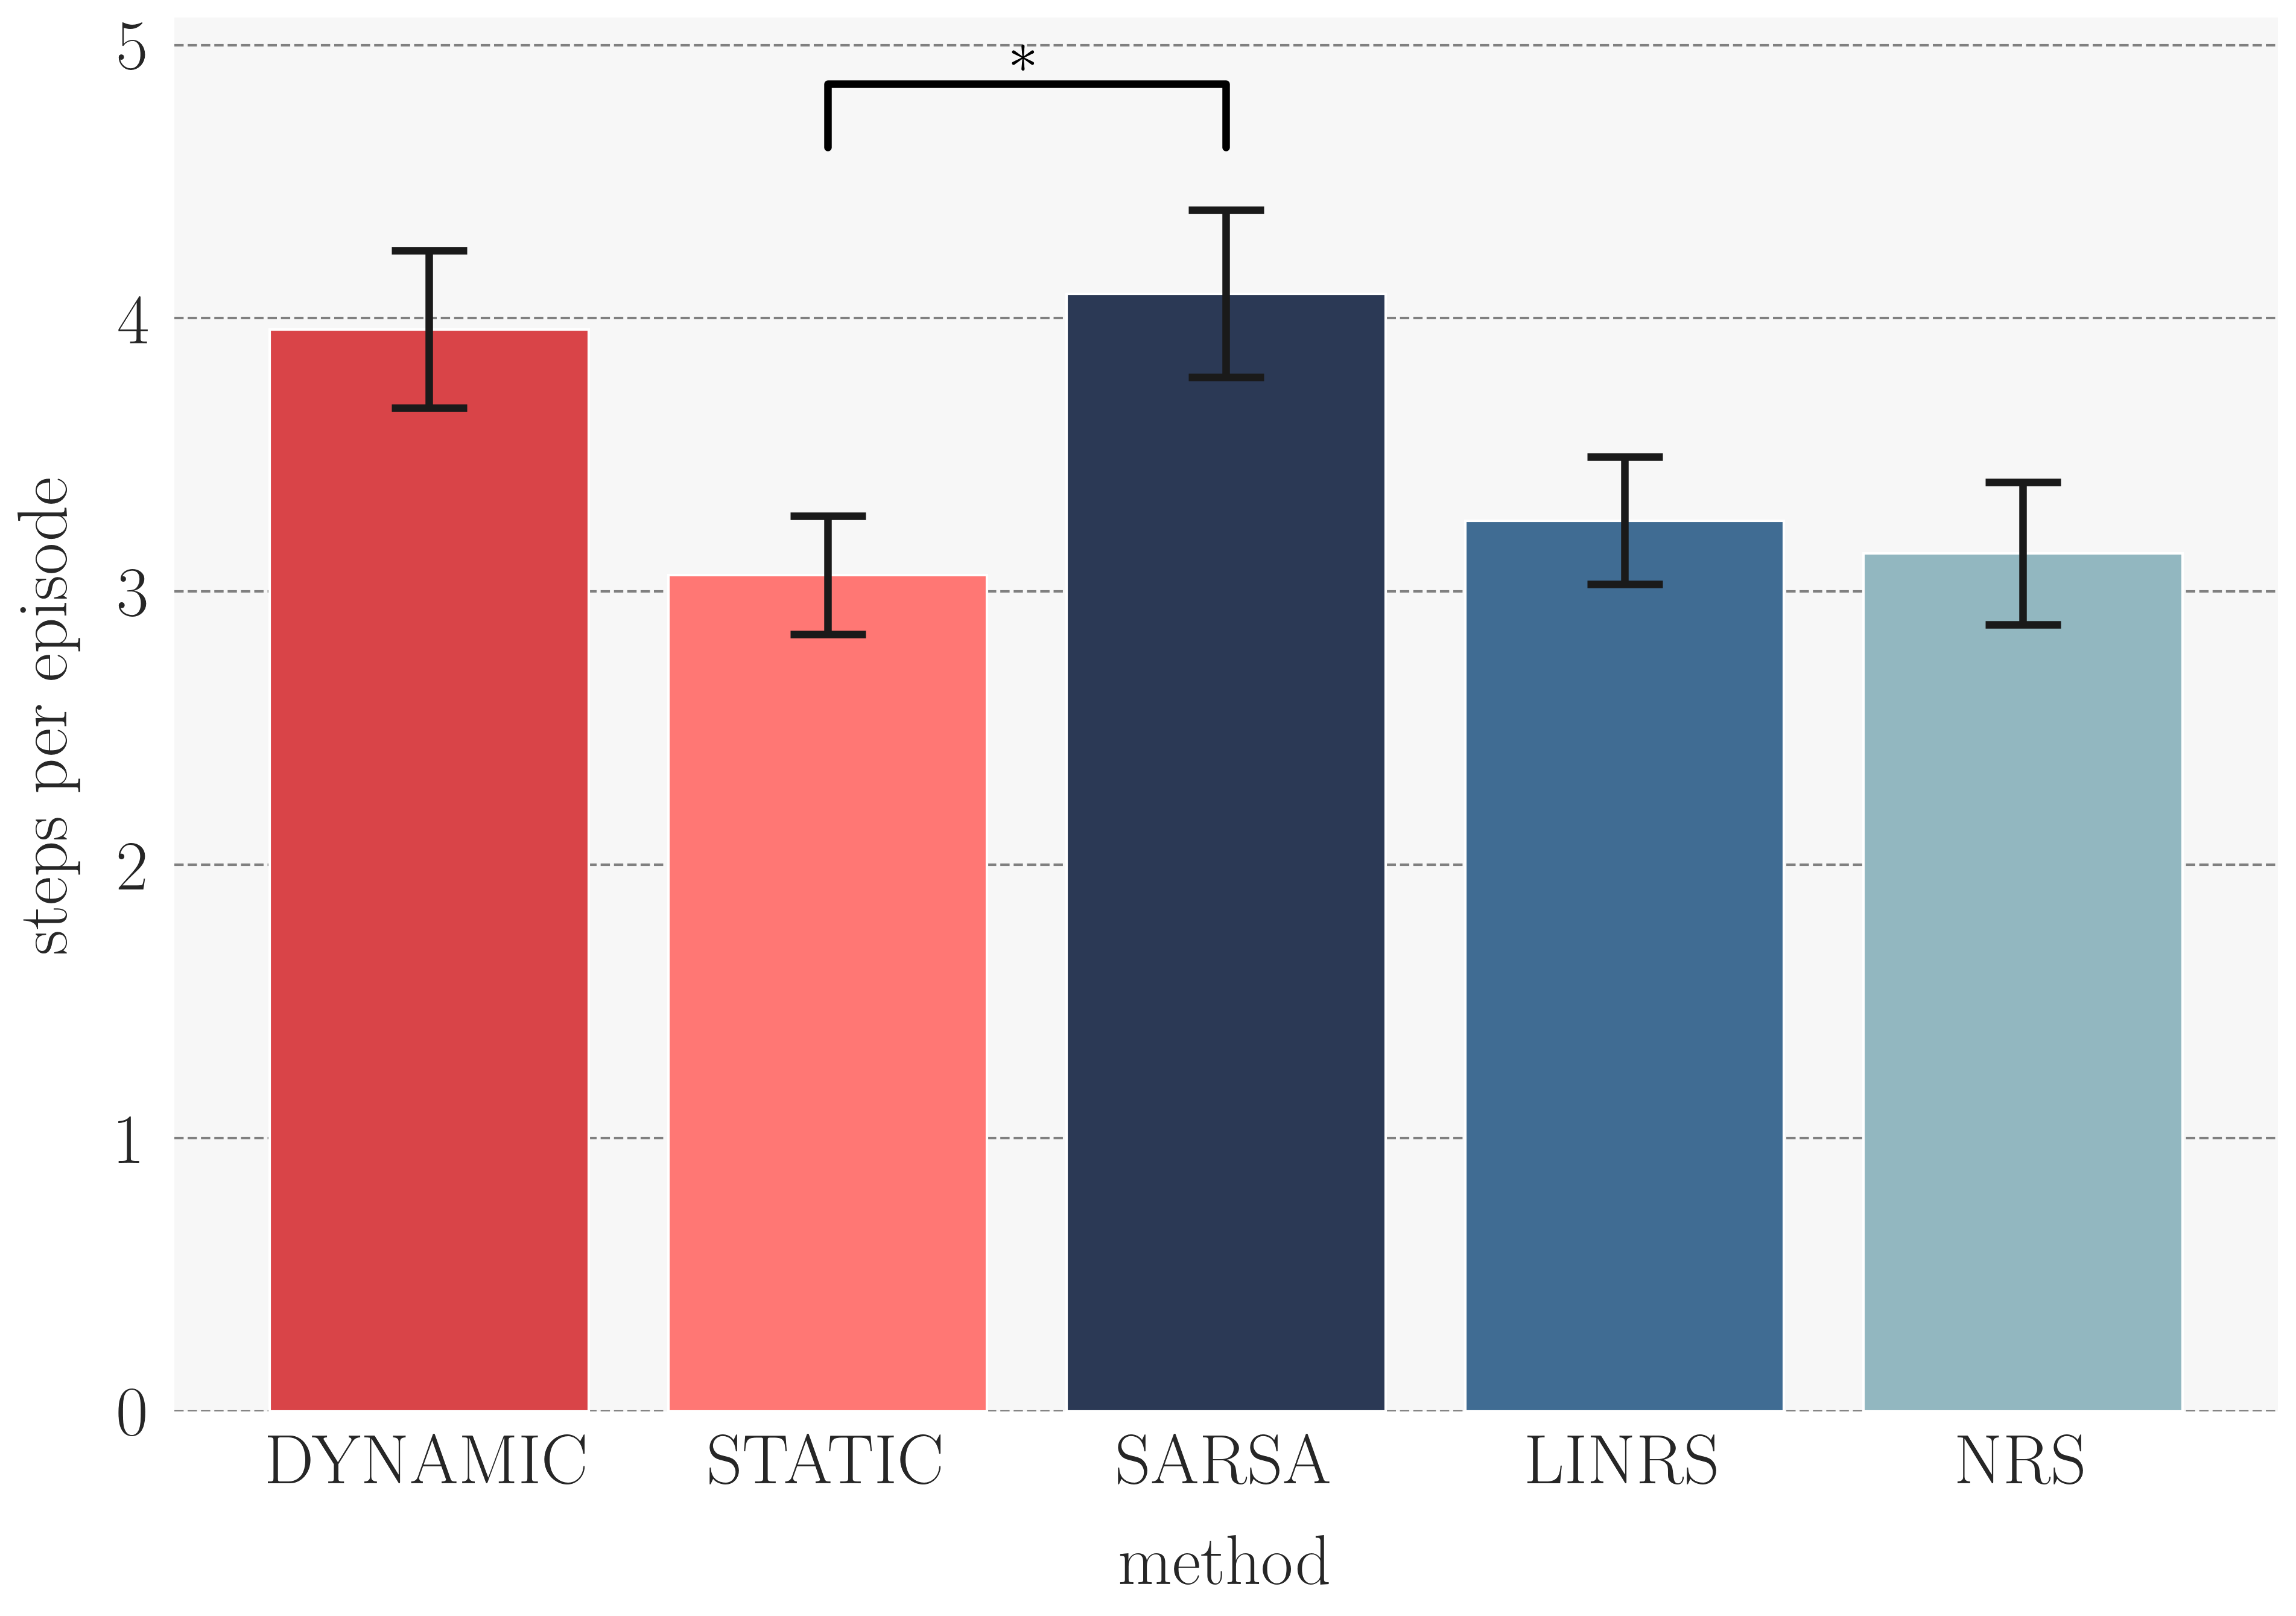

In [50]:
domain = "fourroom"
metric = "time_to_threshold_500"
data_df = pd.read_csv(f"../notebooks/in/{domain}/{metric}.csv", index_col=0)

target_data_df = data_df.loc[:99, ["DYN-HUMAN-", "STATIC-HUMAN-", "SARSA-", "LINRS-", "NRS-"]].rename(
    columns={
        "DYN-HUMAN-": "DYNAMIC", "STATIC-HUMAN-": "STATIC",
        "SARSA-": "SARSA", "LINRS-": "LINRS", "NRS-": "NRS"
    }
)
tuples = [(1, 2, "$*$")]
bar_plot_with_asterisk(metric, domain, target_data_df, tuples)

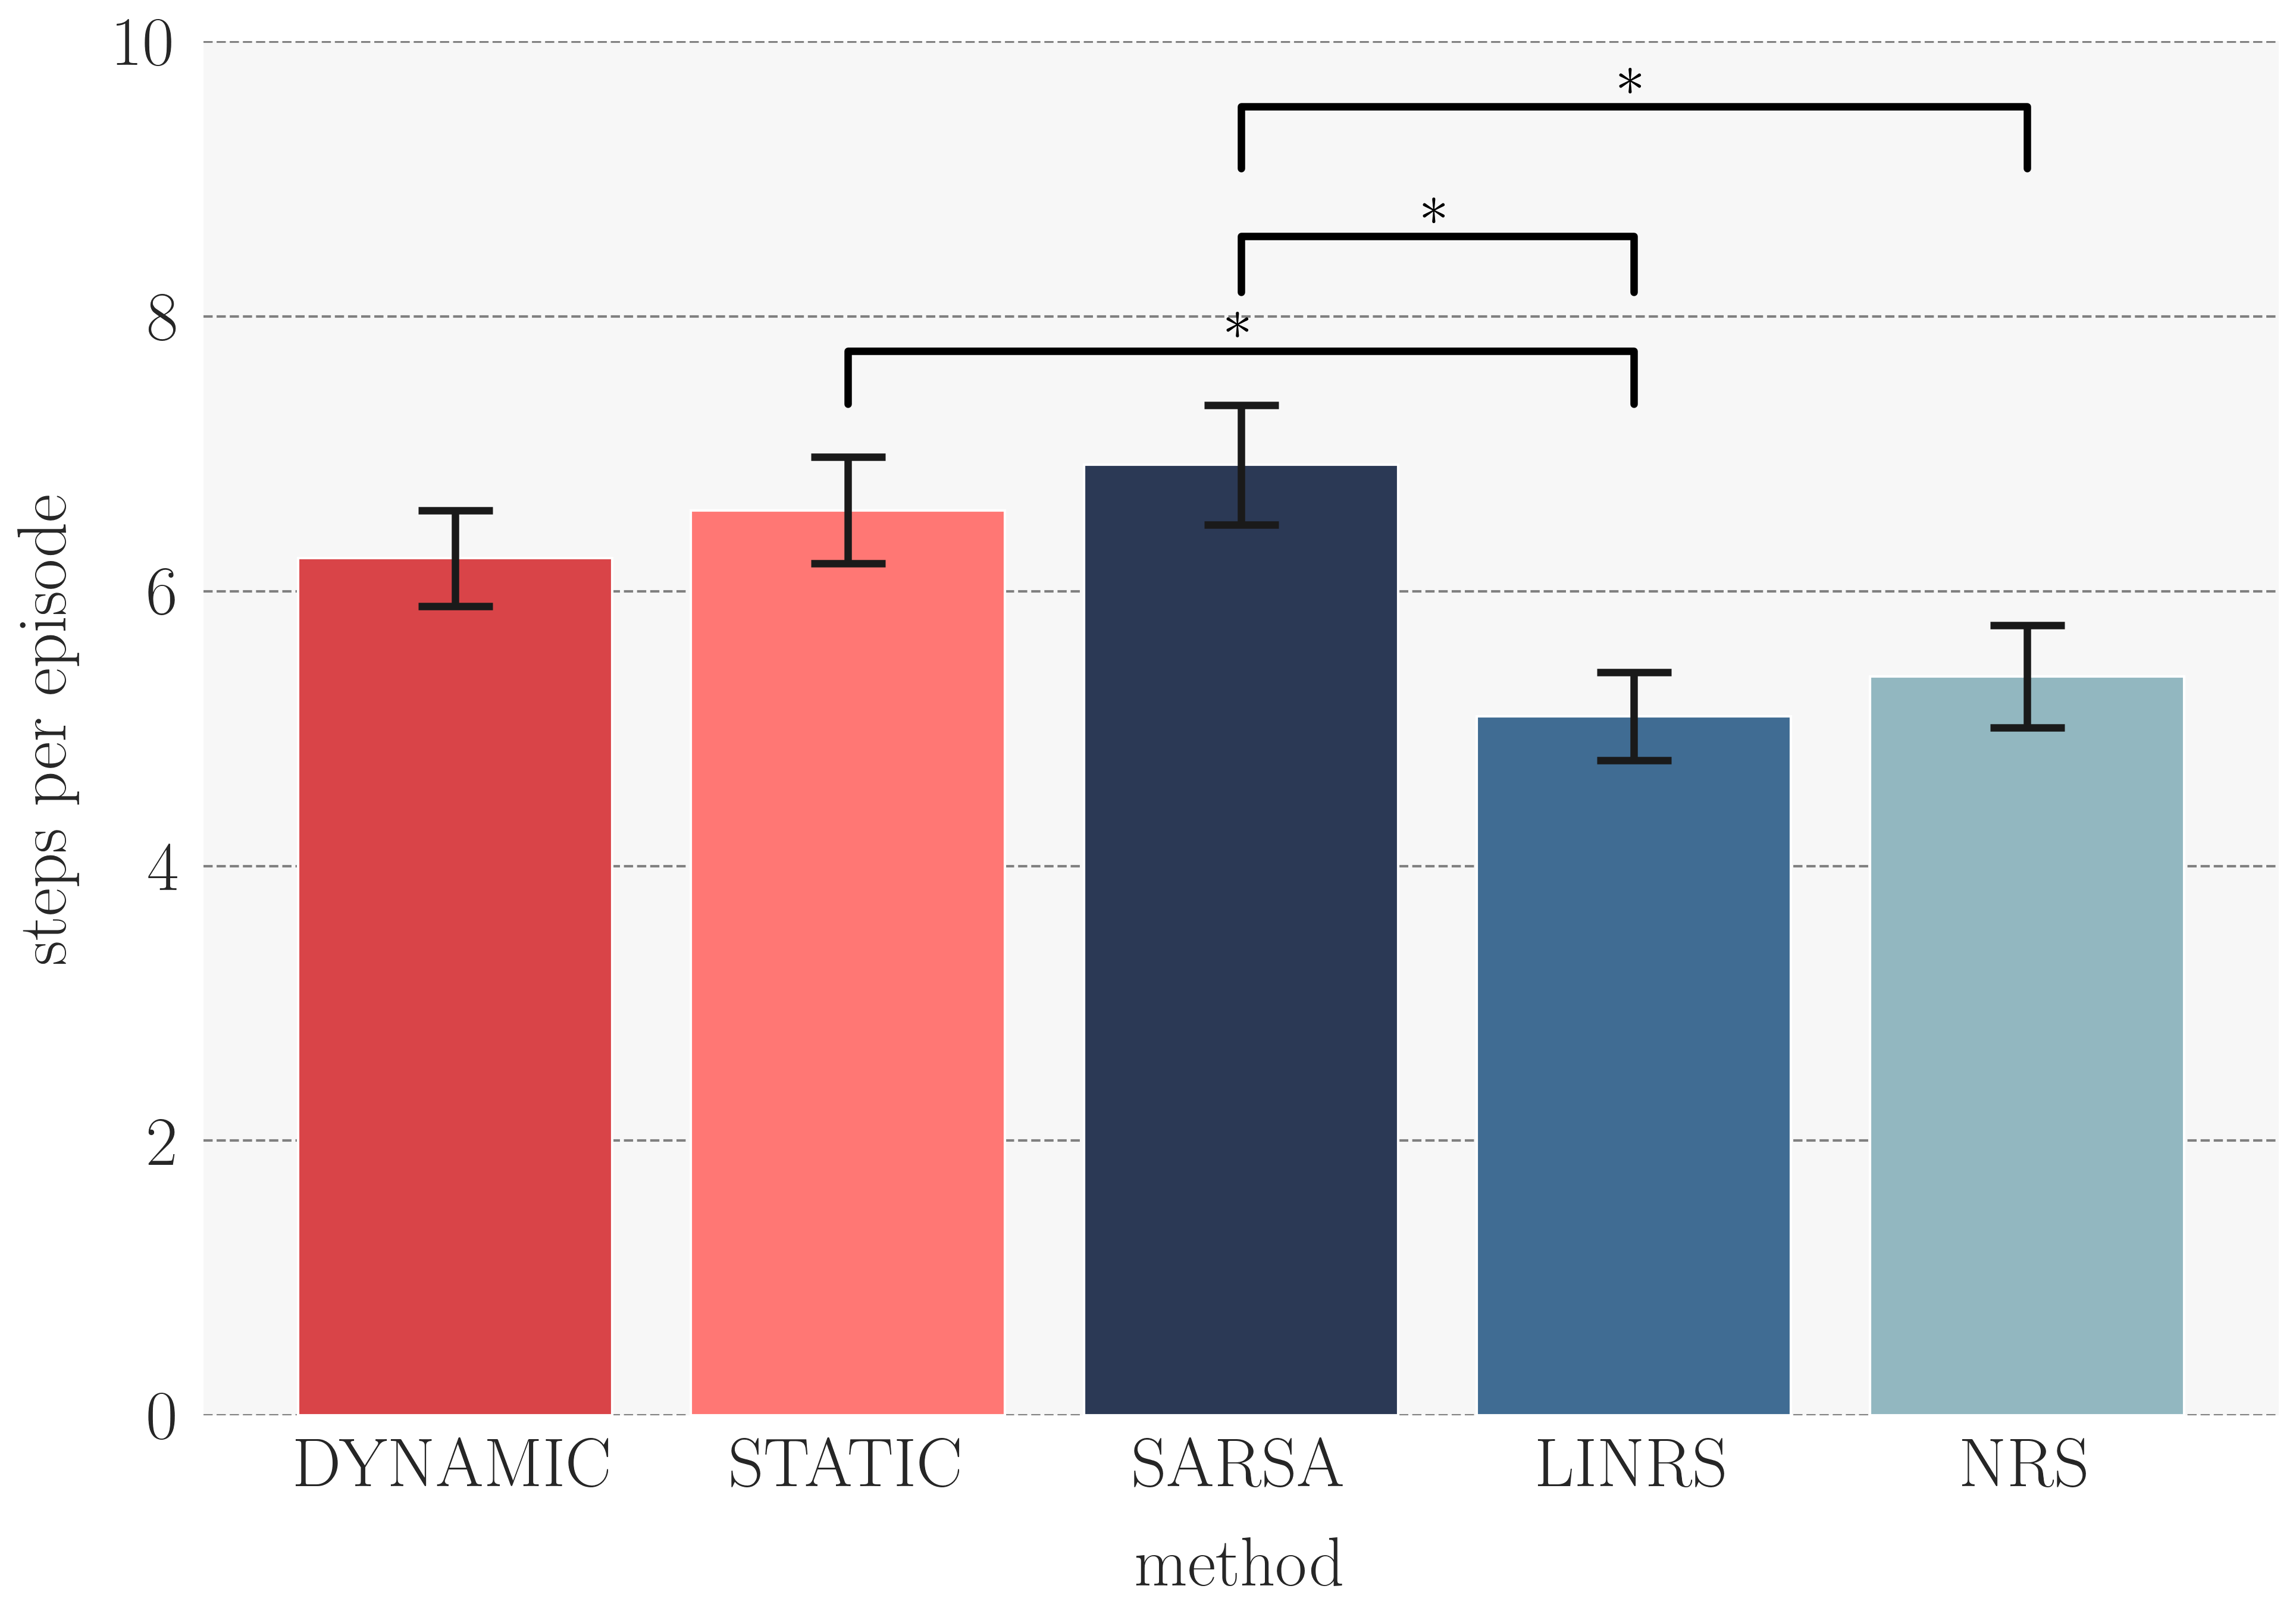

In [51]:
domain = "fourroom"
metric = "time_to_threshold_300"
data_df = pd.read_csv(f"../notebooks/in/{domain}/{metric}.csv", index_col=0)

target_data_df = data_df.loc[:99, ["DYN-HUMAN-", "STATIC-HUMAN-", "SARSA-", "LINRS-", "NRS-"]].rename(
    columns={
        "DYN-HUMAN-": "DYNAMIC", "STATIC-HUMAN-": "STATIC",
        "SARSA-": "SARSA", "LINRS-": "LINRS", "NRS-": "NRS"
    }
)
tuples = [(1, 3, "$*$"), (2, 3, "$*$"), (2, 4, "$*$")]
bar_plot_with_asterisk(metric, domain, target_data_df, tuples)

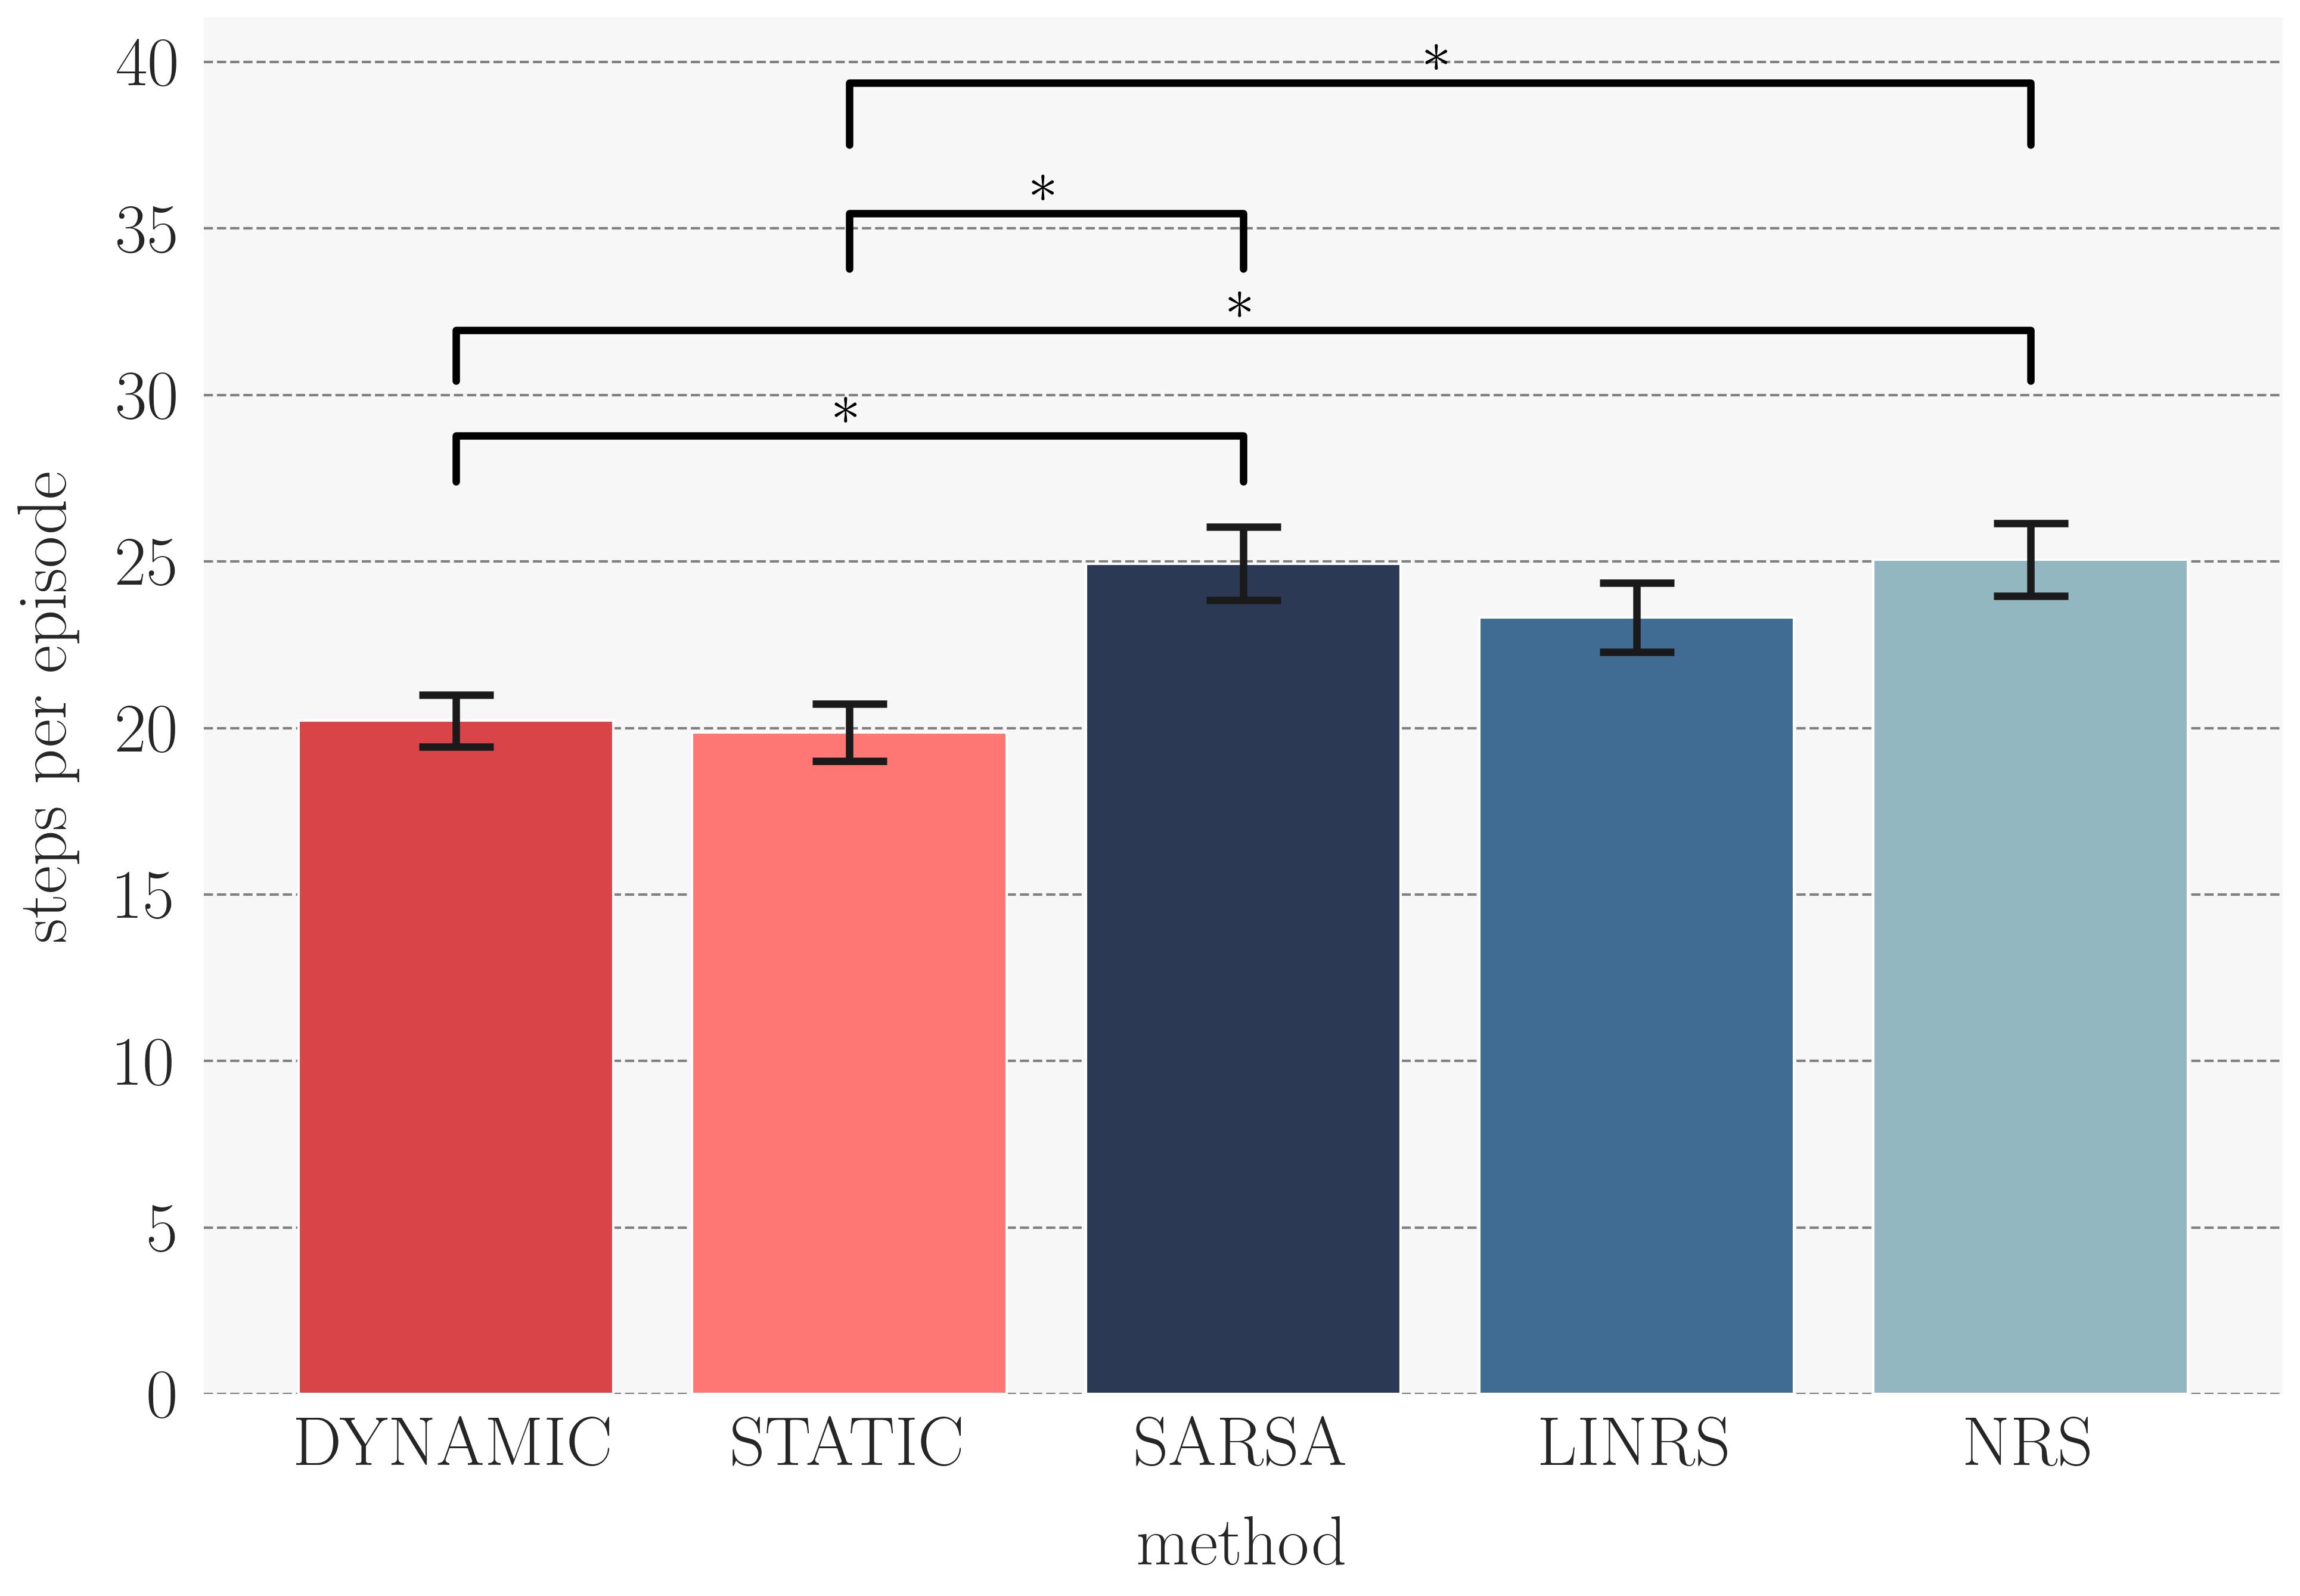

In [52]:
domain = "fourroom"
metric = "time_to_threshold_100"
data_df = pd.read_csv(f"../notebooks/in/{domain}/{metric}.csv", index_col=0)

target_data_df = data_df.loc[:99, ["DYN-HUMAN-", "STATIC-HUMAN-", "SARSA-", "LINRS-", "NRS-"]].rename(
    columns={
        "DYN-HUMAN-": "DYNAMIC", "STATIC-HUMAN-": "STATIC",
        "SARSA-": "SARSA", "LINRS-": "LINRS", "NRS-": "NRS"
    }
)
tuples = [
    (0, 2, "$*$"), (0, 4, "$*$"), (1, 2, "$*$"), (1, 4, "$*$")
]
bar_plot_with_asterisk(metric, domain, target_data_df, tuples)

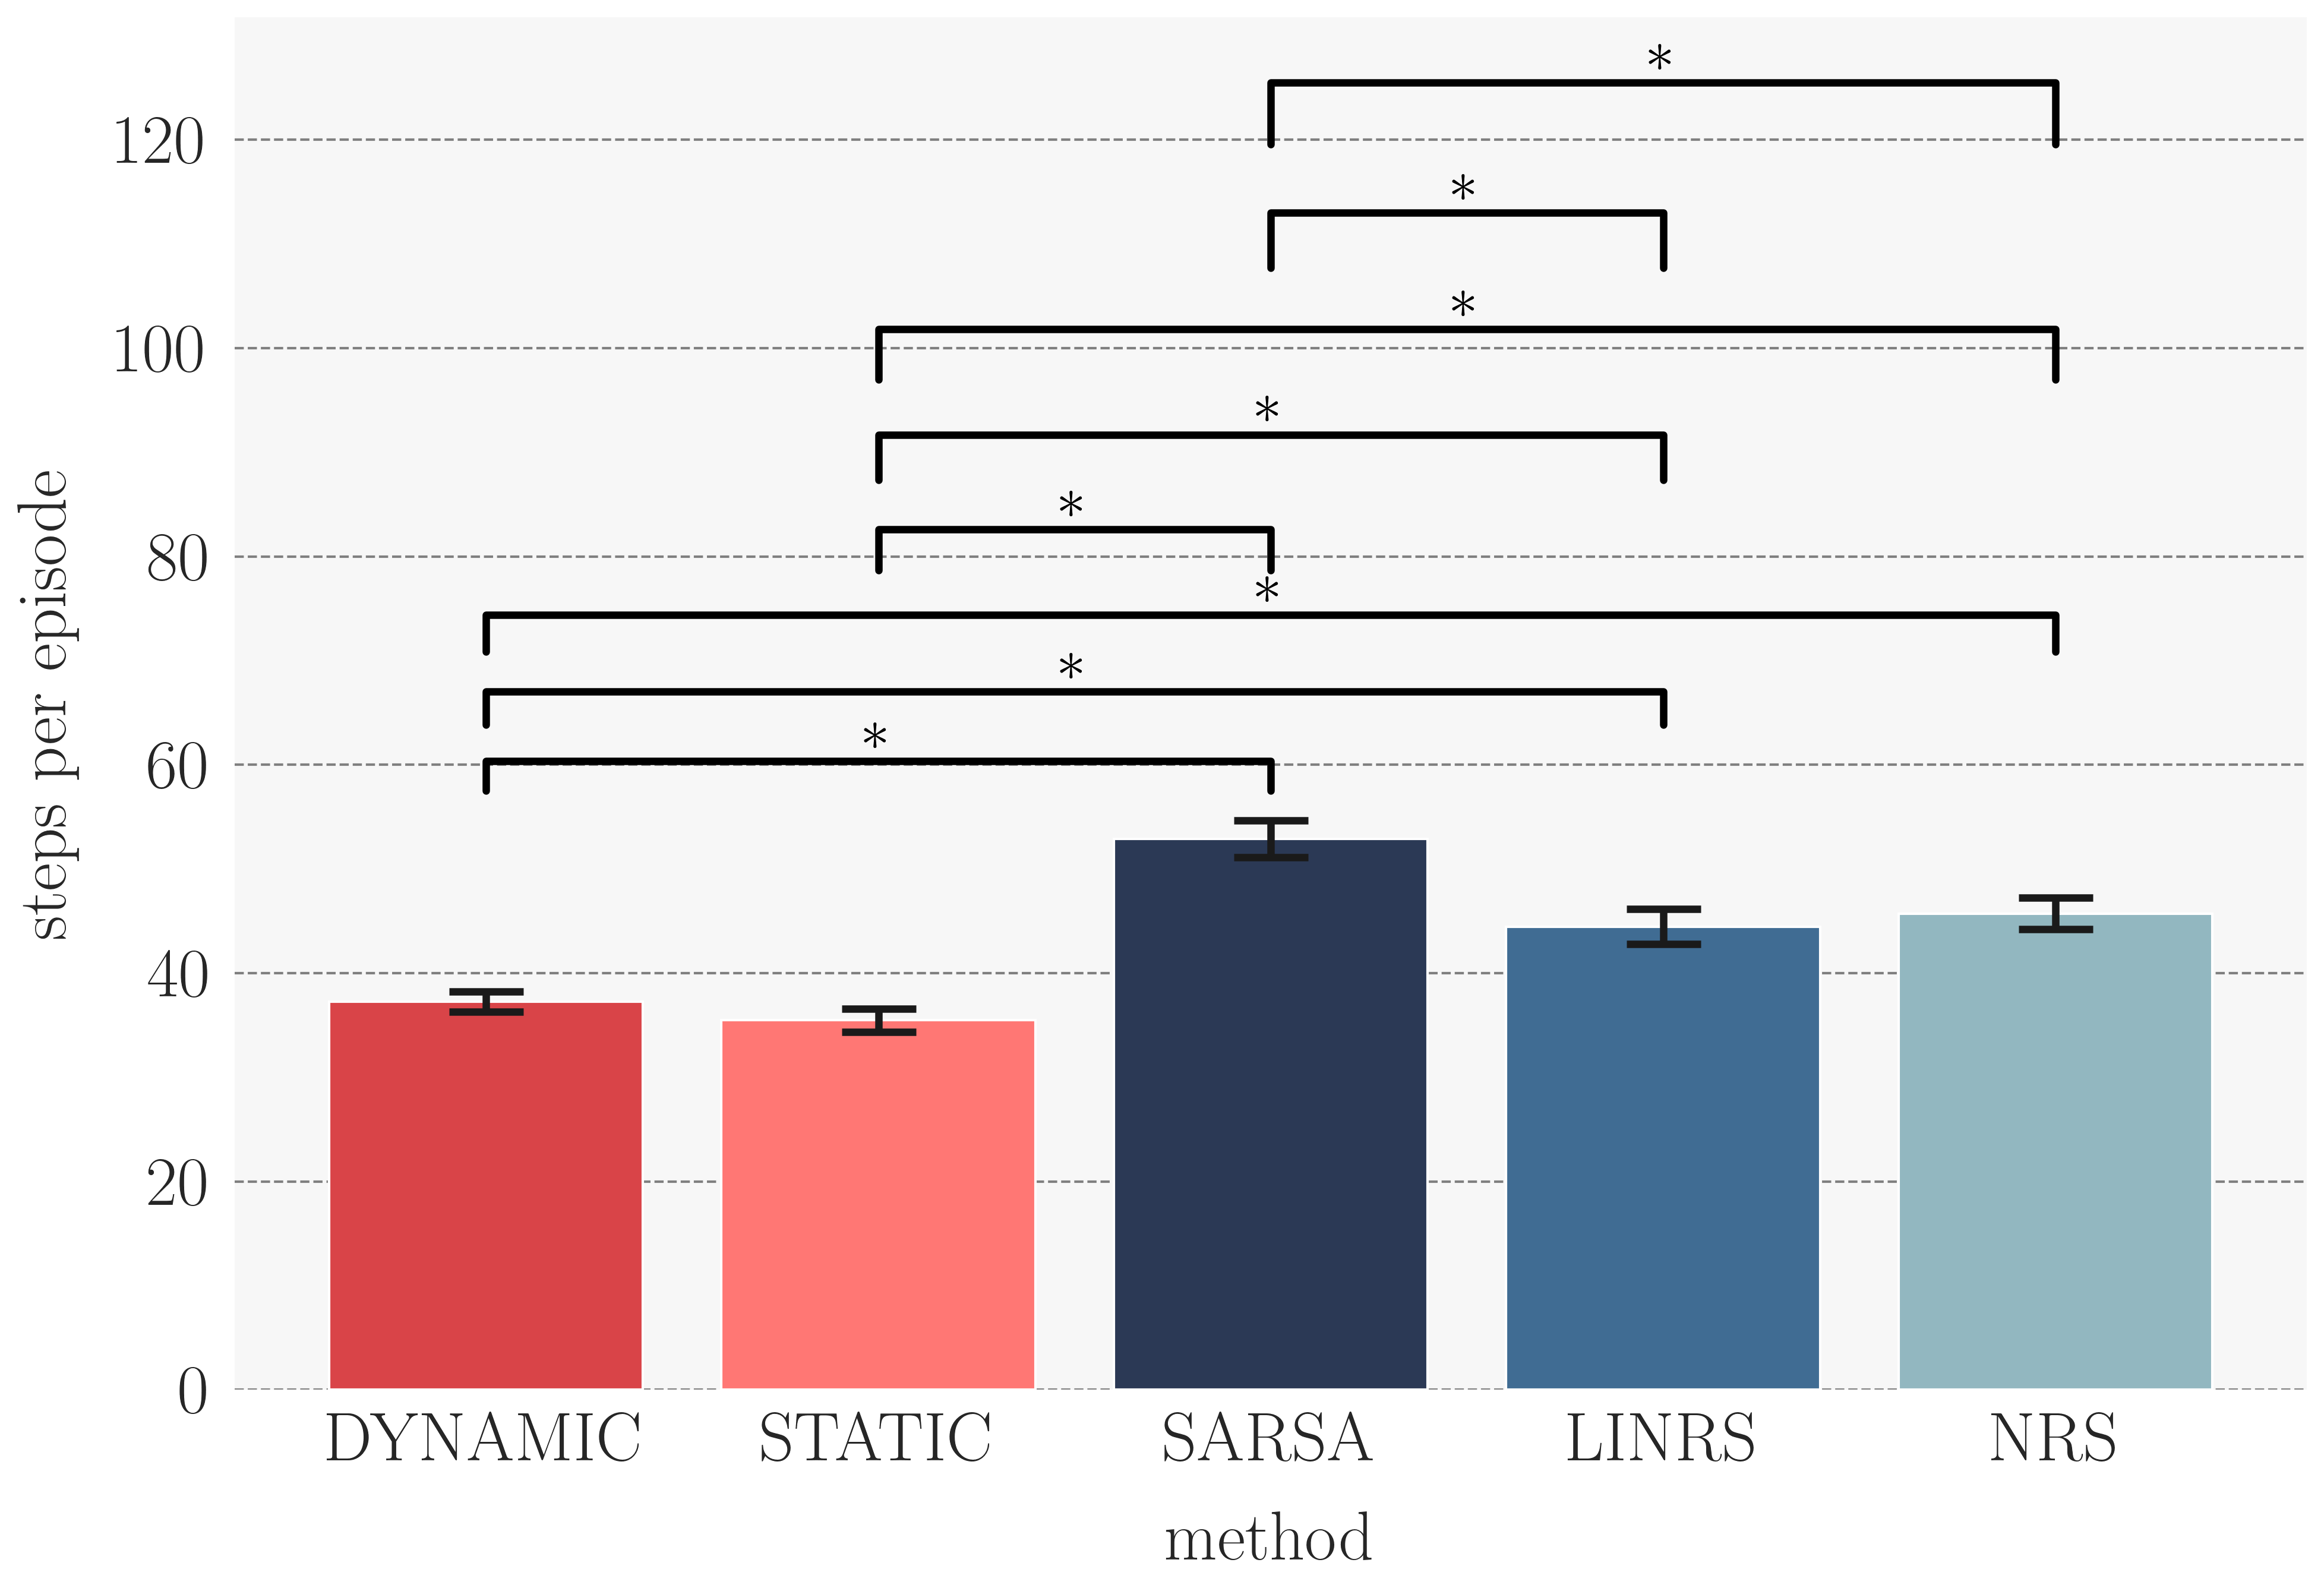

In [ ]:
domain = "fourroom"
metric = "time_to_threshold_50"
data_df = pd.read_csv(f"../notebooks/in/{domain}/{metric}.csv", index_col=0)

target_data_df = data_df.loc[:99, ["DYN-HUMAN-", "STATIC-HUMAN-", "SARSA-", "LINRS-", "NRS-"]].rename(
    columns={
        "DYN-HUMAN-": "DYNAMIC", "STATIC-HUMAN-": "STATIC",
        "SARSA-": "SARSA", "LINRS-": "LINRS", "NRS-": "NRS"
    }
)
tuples = [
    (0, 2, "$*$"), (0, 3, "$*$"), (0, 4, "$*$"), (1, 2, "$*$"), (1, 3, "$*$"), (1, 4, "$*$"),
    (2, 3, "$*$"), (2, 4, "$*$")
]
bar_plot_with_asterisk(metric, domain, target_data_df, tuples)